In [191]:
from ddpg_torch import Agent, MPC_Agent
import gym
import numpy as np
import os
from collections import deque
from copy import deepcopy
# My own env!
from environments import OpenField_v00, OpenField_v01, OpenField_v10, ClosedField_v20, ClosedField_v21, ClosedField_v22, ClosedField_v23_dyna, MPC_environment_v40
import matplotlib.pyplot as plt
import numpy as np


**What tests do we want to run?**

- 

In [192]:
# TRAINING

# v22 FW # 1209 Collisions
#ch = np.loadtxt('plotdata/v22_fw_ch.txt', dtype=int)
#sh = np.loadtxt('plotdata/v22_fw_sh.txt', dtype=float)

# V22 Naples # 
ch = np.loadtxt('plotdata/v22_naples_ch.txt', dtype=int)
sh = np.loadtxt('plotdata/v22_naples_sh.txt', dtype=float)

## V40 FW
#ch = np.loadtxt('plotdata/v40_fw_ch.txt', dtype=int)
#sh = np.loadtxt('plotdata/v40_fw_ch.txt', dtype=float)
#
## V40 Naples
#ch = np.loadtxt('plotdata/v40_naples_ch.txt', dtype=int)
#sh = np.loadtxt('plotdata/v40_naples_ch.txt', dtype=float)


# RUNNING
#ch = np.loadtxt('rundata/v22_fw_data_ch.txt', dtype=int)
#sh = np.loadtxt('rundata/v22_fw_data_sh.txt', dtype=float)

#ch = np.loadtxt('rundata/v40_v22_fw_data_ch.txt', dtype=int)
#sh = np.loadtxt('rundata/v40_v22_fw_data_sh.txt', dtype=float)


#ch = np.loadtxt('rundata/v22_naples_data_ch.txt', dtype=int)
#sh = np.loadtxt('rundata/v22_naples_data_sh.txt', dtype=float)

#ch = np.loadtxt('rundata/v40_v22_naples_data_ch.txt', dtype=int)
#sh = np.loadtxt('rundata/v40_v22_naples_data_sh.txt', dtype=float)


In [193]:
sh

array([-590.76106791, -548.30408735, -523.85692312, ..., 3776.95695097,
       3806.99381675, 3720.01770782])

### Scores

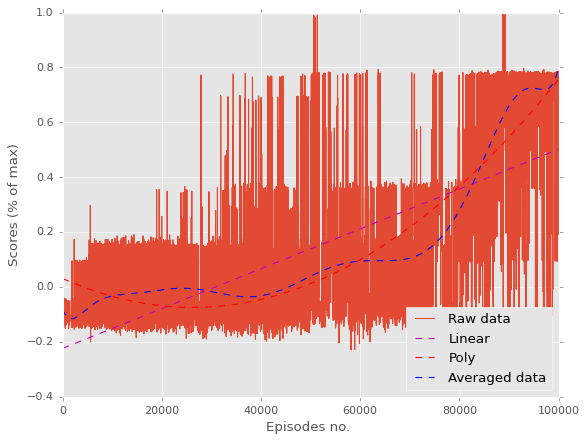

In [196]:
# Normalize the scores
ep_no = len(sh)
ch = ch[0:ep_no]

sh = sh / sh.max()


# Polynomial fit
t = np.linspace(1, ep_no, ep_no)
pfit_1 = np.polyfit(t, sh, 1)
pfit_2 = np.polyfit(t, sh, 2)
pfit_3 = np.polyfit(t, sh, 12)
linear_model = np.poly1d(pfit_1)
poly_model = np.poly1d(pfit_2)
high_poly_model = np.poly1d(pfit_3)


# Time / episode axis
# Moving average
window_width = 1
cumsum_sh = np.cumsum(np.insert(sh, 0, 0)) 
ma_sh = (cumsum_sh[window_width:] - cumsum_sh[:-window_width]) / window_width
t2 = np.linspace(1, ep_no, len(ma_sh))

# Plotting
plt.plot(t, sh, label="Raw data")
plt.plot(t, linear_model(t), "m--", label="Linear")
plt.plot(t, poly_model(t), "r--", label="Poly")
plt.plot(t, high_poly_model(t), "b--", label="Averaged data")
#plt.legend()
#plt.show()
#
#plt.plot(t, sh, label="Raw data")
#plt.plot(t2, ma_sh, label="Raw data")
plt.legend(loc="lower right")

plt.ylabel("Scores (% of max)")
plt.xlabel("Episodes no. ")
plt.show()

### Collisions

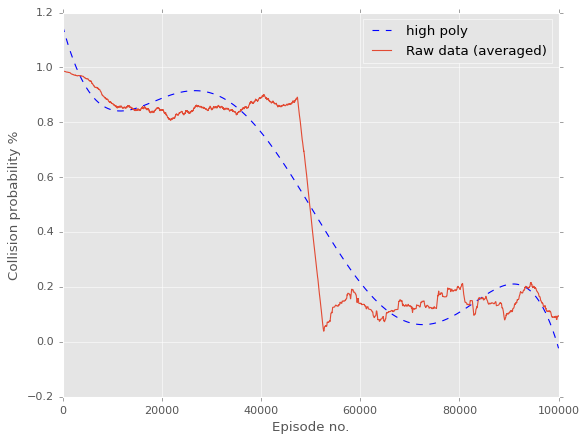

In [195]:

# Polynomial fit
t = np.linspace(1, ep_no, ep_no)
pfit_1 = np.polyfit(t, ch, 1)
pfit_2 = np.polyfit(t, ch, 2)
pfit_3 = np.polyfit(t, ch, 6)
linear_model = np.poly1d(pfit_1)
poly_model = np.poly1d(pfit_2)
high_poly_model = np.poly1d(pfit_3)


# Time / episode axis
# Moving average
window_width = 5000
cumsum_ch = np.cumsum(np.insert(ch, 0, 0)) 
ma_ch = (cumsum_ch[window_width:] - cumsum_ch[:-window_width]) / window_width
t2 = np.linspace(1, ep_no, len(ma_ch))

# Plotting
#plt.plot(t, ch, label="Raw data")
#plt.plot(t, linear_model(t), "m--", label="Linear")3
#plt.plot(t, poly_model(t), "r--", label="Poly")
plt.plot(t, high_poly_model(t), "b--", label="high poly")
#plt.legend()
#plt.show()
#
#plt.plot(t, ch, label="Raw data")
plt.plot(t2, ma_ch, label="Raw data (averaged)")
plt.legend(loc="upper right")


plt.ylabel("Collision probability %")
plt.xlabel("Episode no.")
plt.show()